# EKF SLAM

## Simulation

This is a simulation of EKF SLAM. 

- Black stars: landmarks
- Green crosses: estimates of landmark positions
- Black line: dead reckoning 
- Blue line: ground truth
- Red line: EKF SLAM position estimation

## Introduction

EKF SLAM models the SLAM problem in a single EKF where the modeled state is both the pose $(x, y, \theta)$ and 
an array of landmarks $[(x_1, y_1), (x_2, x_y), ... , (x_n, y_n)]$ for $n$ landmarks. The covariance between each of the positions and landmarks are also tracked.

\begin{equation}
X = \begin{bmatrix} x \\ y \\ \theta \\ x_1 \\ y_1 \\ x_2 \\ y_2 \\ \dots \\ x_n \\ y_n \end{bmatrix}
\end{equation}

\begin{equation}
P = \begin{bmatrix} 
\sigma_{xx} & \sigma_{xy} & \sigma_{x\theta} & \sigma_{xx_1} & \sigma_{xy_1} & \sigma_{xx_2} & \sigma_{xy_2} & \dots & \sigma_{xx_n} & \sigma_{xy_n} \\
\sigma_{yx} & \sigma_{yy} & \sigma_{y\theta} & \sigma_{yx_1} & \sigma_{yy_1} & \sigma_{yx_2} & \sigma_{yy_2} & \dots & \sigma_{yx_n} & \sigma_{yy_n} \\
 &  &  &  & \vdots &  &  &  &  &  \\
\sigma_{x_nx} & \sigma_{x_ny} & \sigma_{x_n\theta} & \sigma_{x_nx_1} & \sigma_{x_ny_1} & \sigma_{x_nx_2} & \sigma_{x_ny_2} & \dots & \sigma_{x_nx_n} & \sigma_{x_ny_n}
\end{bmatrix}
\end{equation}

A single estimate of the pose is tracked over time, while the confidence in the pose is tracked by the 
covariance matrix $P$. $P$ is a symmetric square matrix whith each element in the matrix corresponding to the 
covariance between two parts of the system. For example, $\sigma_{xy}$ represents the covariance between the 
belief of $x$ and $y$ and is equal to $\sigma_{yx}$. 

The state can be represented more concisely as follows.

\begin{equation}
X = \begin{bmatrix} x \\ m \end{bmatrix}
\end{equation}
\begin{equation}
P = \begin{bmatrix} 
\Sigma_{xx} & \Sigma_{xm}\\
\Sigma_{mx} & \Sigma_{mm}\\
\end{bmatrix}
\end{equation}

Here the state simplifies to a combination of pose ($x$) and map ($m$). The covariance matrix becomes easier to 
understand and simply reads as the uncertainty of the robots pose ($\Sigma_{xx}$), the uncertainty of the 
map ($\Sigma_{mm}$), and the uncertainty of the robots pose with respect to the map and vice versa 
($\Sigma_{xm}$, $\Sigma_{mx}$).

Take care to note the difference between $X$ (state) and $x$ (pose).

In [8]:
"""
Extended Kalman Filter SLAM example
original author: Atsushi Sakai (@Atsushi_twi)
notebook author: Andrew Tu (drewtu2)
"""

import math
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt


# EKF state covariance
Cx = np.diag([0.5, 0.5, np.deg2rad(30.0)])**2 # Change in covariance

#  Simulation parameter
Qsim = np.diag([0.2, np.deg2rad(1.0)])**2  # Sensor Noise
Rsim = np.diag([1.0, np.deg2rad(10.0)])**2 # Process Noise

DT = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]
MAX_RANGE = 20.0  # maximum observation range
M_DIST_TH = 2.0  # Threshold of Mahalanobis distance for data association.
STATE_SIZE = 3  # State size [x,y,yaw]
LM_SIZE = 2  # LM state size [x,y]

show_animation = True

## Algorithm Walkthrough

At each time step, the following is done. 
- predict the new state using the control functions
- update the belief in landmark positions based on the estimated state and measurements

In [10]:
def ekf_slam(xEst, PEst, u, z):
    """
    Performs an iteration of EKF SLAM from the available information. 
    
    :param xEst: the belief in last position
    :param PEst: the uncertainty in last position
    :param u:    the control function applied to the last position 
    :param z:    measurements at this step
    :returns:    the next estimated position and associated covariance
    """
    S = STATE_SIZE

    # Predict
    xEst, PEst, G, Fx = predict(xEst, PEst, u)
    initP = np.eye(2)

    # Update
    xEst, PEst = update(xEst, PEst, u, z, initP)

    return xEst, PEst


## 1- Predict
**Predict State update:** The following equations describe the predicted motion model of the robot in case we provide only the control $(v,w)$, which are the linear and angular velocity repsectively. 

$\begin{equation*}
F=
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 
\end{bmatrix}
\end{equation*}$

$\begin{equation*}
B=
\begin{bmatrix}
\Delta t cos(\theta) & 0\\
\Delta t sin(\theta) & 0\\
0 & \Delta t
\end{bmatrix}
\end{equation*}$

$\begin{equation*}
U=
\begin{bmatrix}
v_t\\
w_t\\
\end{bmatrix}
\end{equation*}$

$\begin{equation*}
X = FX + BU 
\end{equation*}$


$\begin{equation*}
\begin{bmatrix}
x_{t+1} \\
y_{t+1} \\
\theta_{t+1}
\end{bmatrix}=
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 
\end{bmatrix}\begin{bmatrix}
x_{t} \\
y_{t} \\
\theta_{t}
\end{bmatrix}+
\begin{bmatrix}
\Delta t cos(\theta) & 0\\
\Delta t sin(\theta) & 0\\
0 & \Delta t
\end{bmatrix}
\begin{bmatrix}
v_{t} + \sigma_v\\
w_{t} + \sigma_w\\
\end{bmatrix}
\end{equation*}$

Notice that while $U$ is only defined by $v_t$ and $w_t$, in the actual calcuations, a $+\sigma_v$ and 
$+\sigma_w$ appear. These values represent the error bewteen the given control inputs and the actual control 
inputs. 

As a result, the simulation is set up as the following. $R$ represents the process noise which is added to the 
control inputs to simulate noise experienced in the real world. A set of truth values are computed from the raw 
control values while the values dead reckoning values incorporate the error into the estimation. 

$\begin{equation*}
R=
\begin{bmatrix}
\sigma_v\\
\sigma_w\\
\end{bmatrix}
\end{equation*}$

$\begin{equation*}
X_{true} = FX + B(U)
\end{equation*}$

$\begin{equation*}
X_{DR} = FX + B(U + R)
\end{equation*}$

The implementation of the motion model prediciton code is shown in `motion_model`. The `observation` function 
shows how the simulation uses (or doesn't use) the process noise `Rsim` to the find the ground truth and dead reckoning estimtates of the pose.

**Predict covariance:** Add the state covariance to the the current uncertainty of the EKF. At each time step, the uncertainty in the system grows by the covariance of the pose, $Cx$. 

$
P = G^TPG + Cx
$

Notice this uncertainty is only growing with respect to the pose, not the landmarks.

In [12]:
def predict(xEst, PEst, u):
    """
    Performs the prediction step of EKF SLAM
    
    :param xEst: nx1 state vector
    :param PEst: nxn covariacne matrix
    :param u:    2x1 control vector
    :returns:    predicted state vector, predicted covariance, jacobian of control vector, transition fx
    """
    S = STATE_SIZE
    xEst[0:S] = motion_model(xEst[0:S], u)
    G, Fx = jacob_motion(xEst[0:S], u)
    # Fx is an an identity matrix of size (STATE_SIZE)
    # sigma = G*sigma*G.T + Noise
    PEst[0:S, 0:S] = G.T * PEst[0:S, 0:S] * G + Fx.T * Cx * Fx
    return xEst, PEst, G, Fx

In [13]:
def motion_model(x, u):
    """
    Computes the motion model based on current state and input function. 
    
    :param x: 3x1 pose estimation
    :param u: 2x1 control input [v; w]
    :returns: the resutling state after the control function is applied
    """
    F = np.array([[1.0, 0, 0],
                  [0, 1.0, 0],
                  [0, 0, 1.0]])

    B = np.array([[DT * math.cos(x[2, 0]), 0],
                  [DT * math.sin(x[2, 0]), 0],
                  [0.0, DT]])

    x = (F @ x) + (B @ u)
    return x

## 2 - Update
In the update phase, the observations of nearby landmarks are used to correct the location estimate. 

For every landmark observed, it is associated to a particular landmark in the known map. If no landmark exists 
in the position surrounding the landmark, it is taken as a NEW landmark. The distance threshold for how far a 
landmark must be from the next known landmark before its considered to be a new landmark is set by `M_DIST_TH`.

With an observation associated to the appropriate landmark, the **innovation** can be calculated. Innovation 
($y$) is the difference between the observation and the observation that *should* have been made if the 
observation were made from the pose predicted in the predict stage.

$
y = z_t - h(X)
$

With the innovation calculated, the question becomes which to trust more - the observations or the predictions? 
To determine this, we calculate the Kalman Gain - a percent of how much of the innovation to add to the 
prediction based on the uncertainty in the predict step and the update step. 

$
K = \bar{P_t}H_t^T(H_t\bar{P_t}H_t^T + Q_t)^{-1}
$
In these equations, $H$ is the jacobian of the measurement function. The multiplications by $H^T$ and $H$ 
represent the application of the delta to the measurement covariance. 
Intuitively, this equation is applying the following from the single variate Kalman equation but in the 
multivariate form, i.e. finding the ratio of the uncertianty of the process compared the measurment. 

$
K = \frac{\bar{P_t}}{\bar{P_t} + Q_t}
$

If $Q_t << \bar{P_t}$, (i.e. the measurement covariance is low relative to the current estimate), then the 
Kalman gain will be $~1$. This results in adding all of the innovation to the estimate -- and therefore 
completely believing the measurement. 

However, if $Q_t >> \bar{P_t}$ then the Kalman gain will go to 0, signaling a high trust in the process 
and little trust in the measurement.

The update is captured in the following. 

$
xUpdate = xEst + (K * y)
$

Of course, the covariance must also be updated as well to account for the changing uncertainty. 

$
P_{t} = (I-K_tH_t)\bar{P_t}
$

In [15]:
def update(xEst, PEst, u, z, initP):
    """
    Performs the update step of EKF SLAM
    
    :param xEst:  nx1 the predicted pose of the system and the pose of the landmarks
    :param PEst:  nxn the predicted covariance
    :param u:     2x1 the control function 
    :param z:     the measurements read at new position
    :param initP: 2x2 an identity matrix acting as the initial covariance
    :returns:     the updated state and covariance for the system
    """
    for iz in range(len(z[:, 0])):  # for each observation
        minid = search_correspond_LM_ID(xEst, PEst, z[iz, 0:2]) # associate to a known landmark

        nLM = calc_n_LM(xEst) # number of landmarks we currently know about
        
        if minid == nLM: # Landmark is a NEW landmark
            print("New LM")
            # Extend state and covariance matrix
            xAug = np.vstack((xEst, calc_LM_Pos(xEst, z[iz, :])))
            PAug = np.vstack((np.hstack((PEst, np.zeros((len(xEst), LM_SIZE)))),
                              np.hstack((np.zeros((LM_SIZE, len(xEst))), initP))))
            xEst = xAug
            PEst = PAug
        
        lm = get_LM_Pos_from_state(xEst, minid)
        y, S, H = calc_innovation(lm, xEst, PEst, z[iz, 0:2], minid)

        K = (PEst @ H.T) @ np.linalg.inv(S) # Calculate Kalman Gain
        xEst = xEst + (K @ y)
        PEst = (np.eye(len(xEst)) - (K @ H)) @ PEst
    
    xEst[2] = pi_2_pi(xEst[2])
    return xEst, PEst


In [16]:
def calc_innovation(lm, xEst, PEst, z, LMid):
    """
    Calculates the innovation based on expected position and landmark position
    
    :param lm:   landmark position
    :param xEst: estimated position/state
    :param PEst: estimated covariance
    :param z:    read measurements
    :param LMid: landmark id
    :returns:    returns the innovation y, and the jacobian H, and S, used to calculate the Kalman Gain
    """
    delta = lm - xEst[0:2]
    q = (delta.T @ delta)[0, 0]
    zangle = math.atan2(delta[1, 0], delta[0, 0]) - xEst[2, 0]
    zp = np.array([[math.sqrt(q), pi_2_pi(zangle)]])
    # zp is the expected measurement based on xEst and the expected landmark position
    
    y = (z - zp).T # y = innovation
    y[1] = pi_2_pi(y[1])
    
    H = jacobH(q, delta, xEst, LMid + 1)
    S = H @ PEst @ H.T + Cx[0:2, 0:2]

    return y, S, H

def jacobH(q, delta, x, i):
    """
    Calculates the jacobian of the measurement function
    
    :param q:     the range from the system pose to the landmark
    :param delta: the difference between a landmark position and the estimated system position
    :param x:     the state, including the estimated system position
    :param i:     landmark id + 1
    :returns:     the jacobian H
    """
    sq = math.sqrt(q)
    G = np.array([[-sq * delta[0, 0], - sq * delta[1, 0], 0, sq * delta[0, 0], sq * delta[1, 0]],
                  [delta[1, 0], - delta[0, 0], - 1.0, - delta[1, 0], delta[0, 0]]])

    G = G / q
    nLM = calc_n_LM(x)
    F1 = np.hstack((np.eye(3), np.zeros((3, 2 * nLM))))
    F2 = np.hstack((np.zeros((2, 3)), np.zeros((2, 2 * (i - 1))),
                    np.eye(2), np.zeros((2, 2 * nLM - 2 * i))))

    F = np.vstack((F1, F2))

    H = G @ F

    return H

## Observation Step
The observation step described here is outside the main EKF SLAM process and is primarily used as a method of
driving the simulation. The observations funciton is in charge of calcualting how the poses of the robots change 
and accumulate error over time, and the theoretical measuremnts that are expected as a result of each 
measurement. 

Observations are based on the TRUE position of the robot. Error in dead reckoning and control functions are 
passed along here as well.

In [18]:
def observation(xTrue, xd, u, RFID):
    """
    :param xTrue: the true pose of the system
    :param xd:    the current noisy estimate of the system
    :param u:     the current control input
    :param RFID:  the true position of the landmarks
    
    :returns:     Computes the true position, observations, dead reckoning (noisy) position, 
                  and noisy control function
    """
    xTrue = motion_model(xTrue, u)

    # add noise to gps x-y
    z = np.zeros((0, 3))

    for i in range(len(RFID[:, 0])): # Test all beacons, only add the ones we can see (within MAX_RANGE)

        dx = RFID[i, 0] - xTrue[0, 0]
        dy = RFID[i, 1] - xTrue[1, 0]
        d = math.sqrt(dx**2 + dy**2)
        angle = pi_2_pi(math.atan2(dy, dx) - xTrue[2, 0])
        if d <= MAX_RANGE:
            dn = d + np.random.randn() * Qsim[0, 0]  # add noise
            anglen = angle + np.random.randn() * Qsim[1, 1]  # add noise
            zi = np.array([dn, anglen, i])
            z = np.vstack((z, zi))

    # add noise to input
    ud = np.array([[
        u[0, 0] + np.random.randn() * Rsim[0, 0],
        u[1, 0] + np.random.randn() * Rsim[1, 1]]]).T

    xd = motion_model(xd, ud)
    return xTrue, z, xd, ud

In [19]:
def calc_n_LM(x):
    """
    Calculates the number of landmarks currently tracked in the state
    :param x: the state
    :returns: the number of landmarks n
    """
    n = int((len(x) - STATE_SIZE) / LM_SIZE)
    return n


def jacob_motion(x, u):
    """
    Calculates the jacobian of motion model. 
    
    :param x: The state, including the estimated position of the system
    :param u: The control function
    :returns: G:  Jacobian
              Fx: STATE_SIZE x (STATE_SIZE + 2 * num_landmarks) matrix where the left side is an identity matrix
    """
    
    # [eye(3) [0 x y; 0 x y; 0 x y]]
    Fx = np.hstack((np.eye(STATE_SIZE), np.zeros(
        (STATE_SIZE, LM_SIZE * calc_n_LM(x)))))

    jF = np.array([[0.0, 0.0, -DT * u[0] * math.sin(x[2, 0])],
                   [0.0, 0.0, DT * u[0] * math.cos(x[2, 0])],
                   [0.0, 0.0, 0.0]])

    G = np.eye(STATE_SIZE) + Fx.T * jF * Fx
    if calc_n_LM(x) > 0:
        print(Fx.shape)
    return G, Fx,




In [20]:
def calc_LM_Pos(x, z):
    """
    Calcualtes the pose in the world coordinate frame of a landmark at the given measurement. 

    :param x: [x; y; theta]
    :param z: [range; bearing]
    :returns: [x; y] for given measurement
    """
    zp = np.zeros((2, 1))

    zp[0, 0] = x[0, 0] + z[0] * math.cos(x[2, 0] + z[1])
    zp[1, 0] = x[1, 0] + z[0] * math.sin(x[2, 0] + z[1])
    #zp[0, 0] = x[0, 0] + z[0, 0] * math.cos(x[2, 0] + z[0, 1])
    #zp[1, 0] = x[1, 0] + z[0, 0] * math.sin(x[2, 0] + z[0, 1])

    return zp


def get_LM_Pos_from_state(x, ind):
    """
    Returns the position of a given landmark
    
    :param x:   The state containing all landmark positions
    :param ind: landmark id
    :returns:   The position of the landmark
    """
    lm = x[STATE_SIZE + LM_SIZE * ind: STATE_SIZE + LM_SIZE * (ind + 1), :]

    return lm


def search_correspond_LM_ID(xAug, PAug, zi):
    """
    Landmark association with Mahalanobis distance.
    
    If this landmark is at least M_DIST_TH units away from all known landmarks, 
    it is a NEW landmark.
    
    :param xAug: The estimated state
    :param PAug: The estimated covariance
    :param zi:   the read measurements of specific landmark
    :returns:    landmark id
    """

    nLM = calc_n_LM(xAug)

    mdist = []

    for i in range(nLM):
        lm = get_LM_Pos_from_state(xAug, i)
        y, S, H = calc_innovation(lm, xAug, PAug, zi, i)
        mdist.append(y.T @ np.linalg.inv(S) @ y)

    mdist.append(M_DIST_TH)  # new landmark

    minid = mdist.index(min(mdist))

    return minid

def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.array([[v, yawrate]]).T
    return u

def pi_2_pi(angle):
    return (angle + math.pi) % (2 * math.pi) - math.pi

In [21]:
def main():
    print(" start!!")

    time = 0.0

    # RFID positions [x, y]
    RFID = np.array([[10.0, -2.0],
                     [15.0, 10.0],
                     [3.0, 15.0],
                     [-5.0, 20.0]])

    # State Vector [x y yaw v]'
    xEst = np.zeros((STATE_SIZE, 1))
    xTrue = np.zeros((STATE_SIZE, 1))
    PEst = np.eye(STATE_SIZE)

    xDR = np.zeros((STATE_SIZE, 1))  # Dead reckoning

    # history
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue

    while SIM_TIME >= time:
        time += DT
        u = calc_input()

        xTrue, z, xDR, ud = observation(xTrue, xDR, u, RFID)

        xEst, PEst = ekf_slam(xEst, PEst, ud, z)

        x_state = xEst[0:STATE_SIZE]

        # store data history
        hxEst = np.hstack((hxEst, x_state))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))

        if show_animation:  # pragma: no cover
            fig, ax = plt.subplots()
            plt.cla()

            plt.plot(RFID[:, 0], RFID[:, 1], "*k")
            plt.plot(xEst[0], xEst[1], ".r")

            # plot landmark
            for i in range(calc_n_LM(xEst)):
                plt.plot(xEst[STATE_SIZE + i * 2],
                         xEst[STATE_SIZE + i * 2 + 1], "xg")

            plt.plot(hxTrue[0, :],
                     hxTrue[1, :], "-b")
            plt.plot(hxDR[0, :],
                     hxDR[1, :], "-k")
            plt.plot(hxEst[0, :],
                     hxEst[1, :], "-r")
            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.001)
            display(fig)

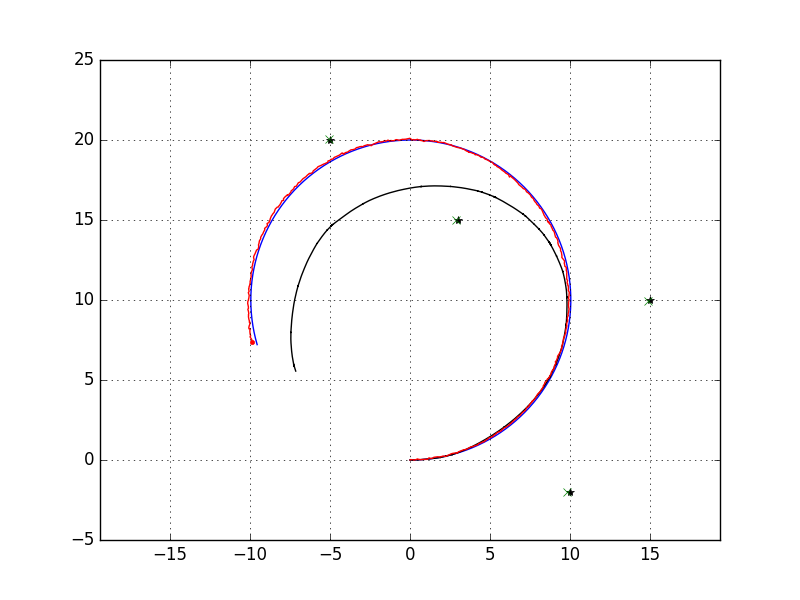

In [22]:
#%matplotlib notebook
#%matplotlib notebook
main()